## Extracting Chess Squares with Perspective Transformation ( image --> fen format)

<br>
<font size="4">
Notebook version of perspective_transformation.py file. You can  understand better all the process by observing cell by cell.<br>  You can use this file for testing 
</font>
<br><br><br><br>

<br>

#### Necessary Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from ultralytics import YOLO
import  math
import csv
#from svglib.svglib import svg2rlg
#from reportlab.graphics import renderPM
from PIL import Image
import os
import chess
import chess.svg


<br>

#### Display Image

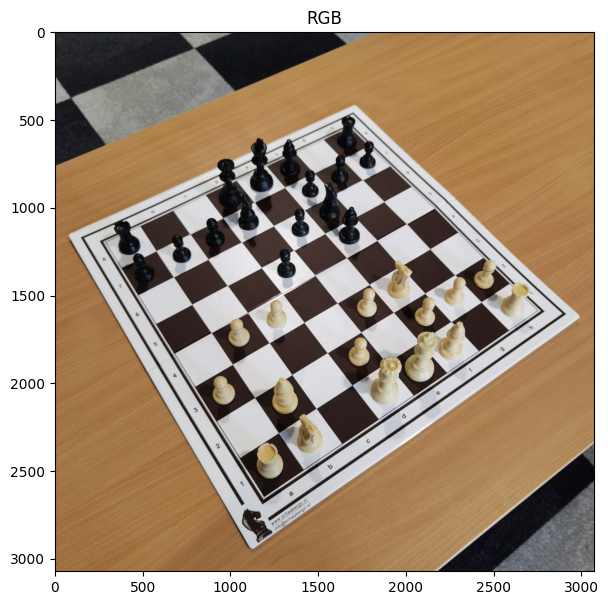

In [14]:
# Path of Image that you want to convert
image_path = r"test-images/test-5.jpeg"
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\87\G087_IMG035.jpg"
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\0\G000_IMG011.jpg"
# image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\42\G042_IMG000.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\Dynamic-Chess-Board-Piece-Extraction-master\test-images\test-12.jpeg"


# read image and convert it to different color spaces 
image = cv2.imread(image_path)
#image = cv2.resize(image, (1000, 1000))

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

original_size = 1200
scale_factor = image.shape[0] / original_size

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

<br>


## Processing Image 
####  OTSU Threshold , Canny , dilate , HoughLinesP

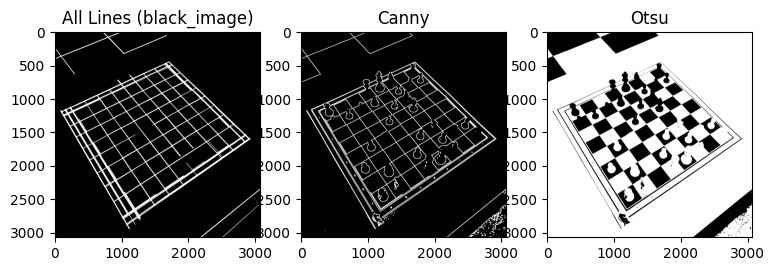

In [15]:

# OTSU threshold
blurred_image = cv2.GaussianBlur(gray_image,(5,5),0)
ret, otsu_binary = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
canny_image = cv2.Canny(otsu_binary, 20, 255)

# Dilation
kernel = np.ones((7, 7), np.uint8)
dilation_image = cv2.dilate(canny_image, kernel, iterations=1)

# Hough Lines
lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)
# lines = link_and_merge_segments_array(lines[:, 0], image.shape[0]*image.shape[1])

# Create an image that contains only black pixels
black_image = np.zeros_like(dilation_image)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))

plt.subplot(1, 3, 1)
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray")


plt.subplot(1, 3, 2)
plt.title("Canny")
plt.imshow(dilation_image,cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Otsu")
plt.imshow(otsu_binary,cmap="gray")

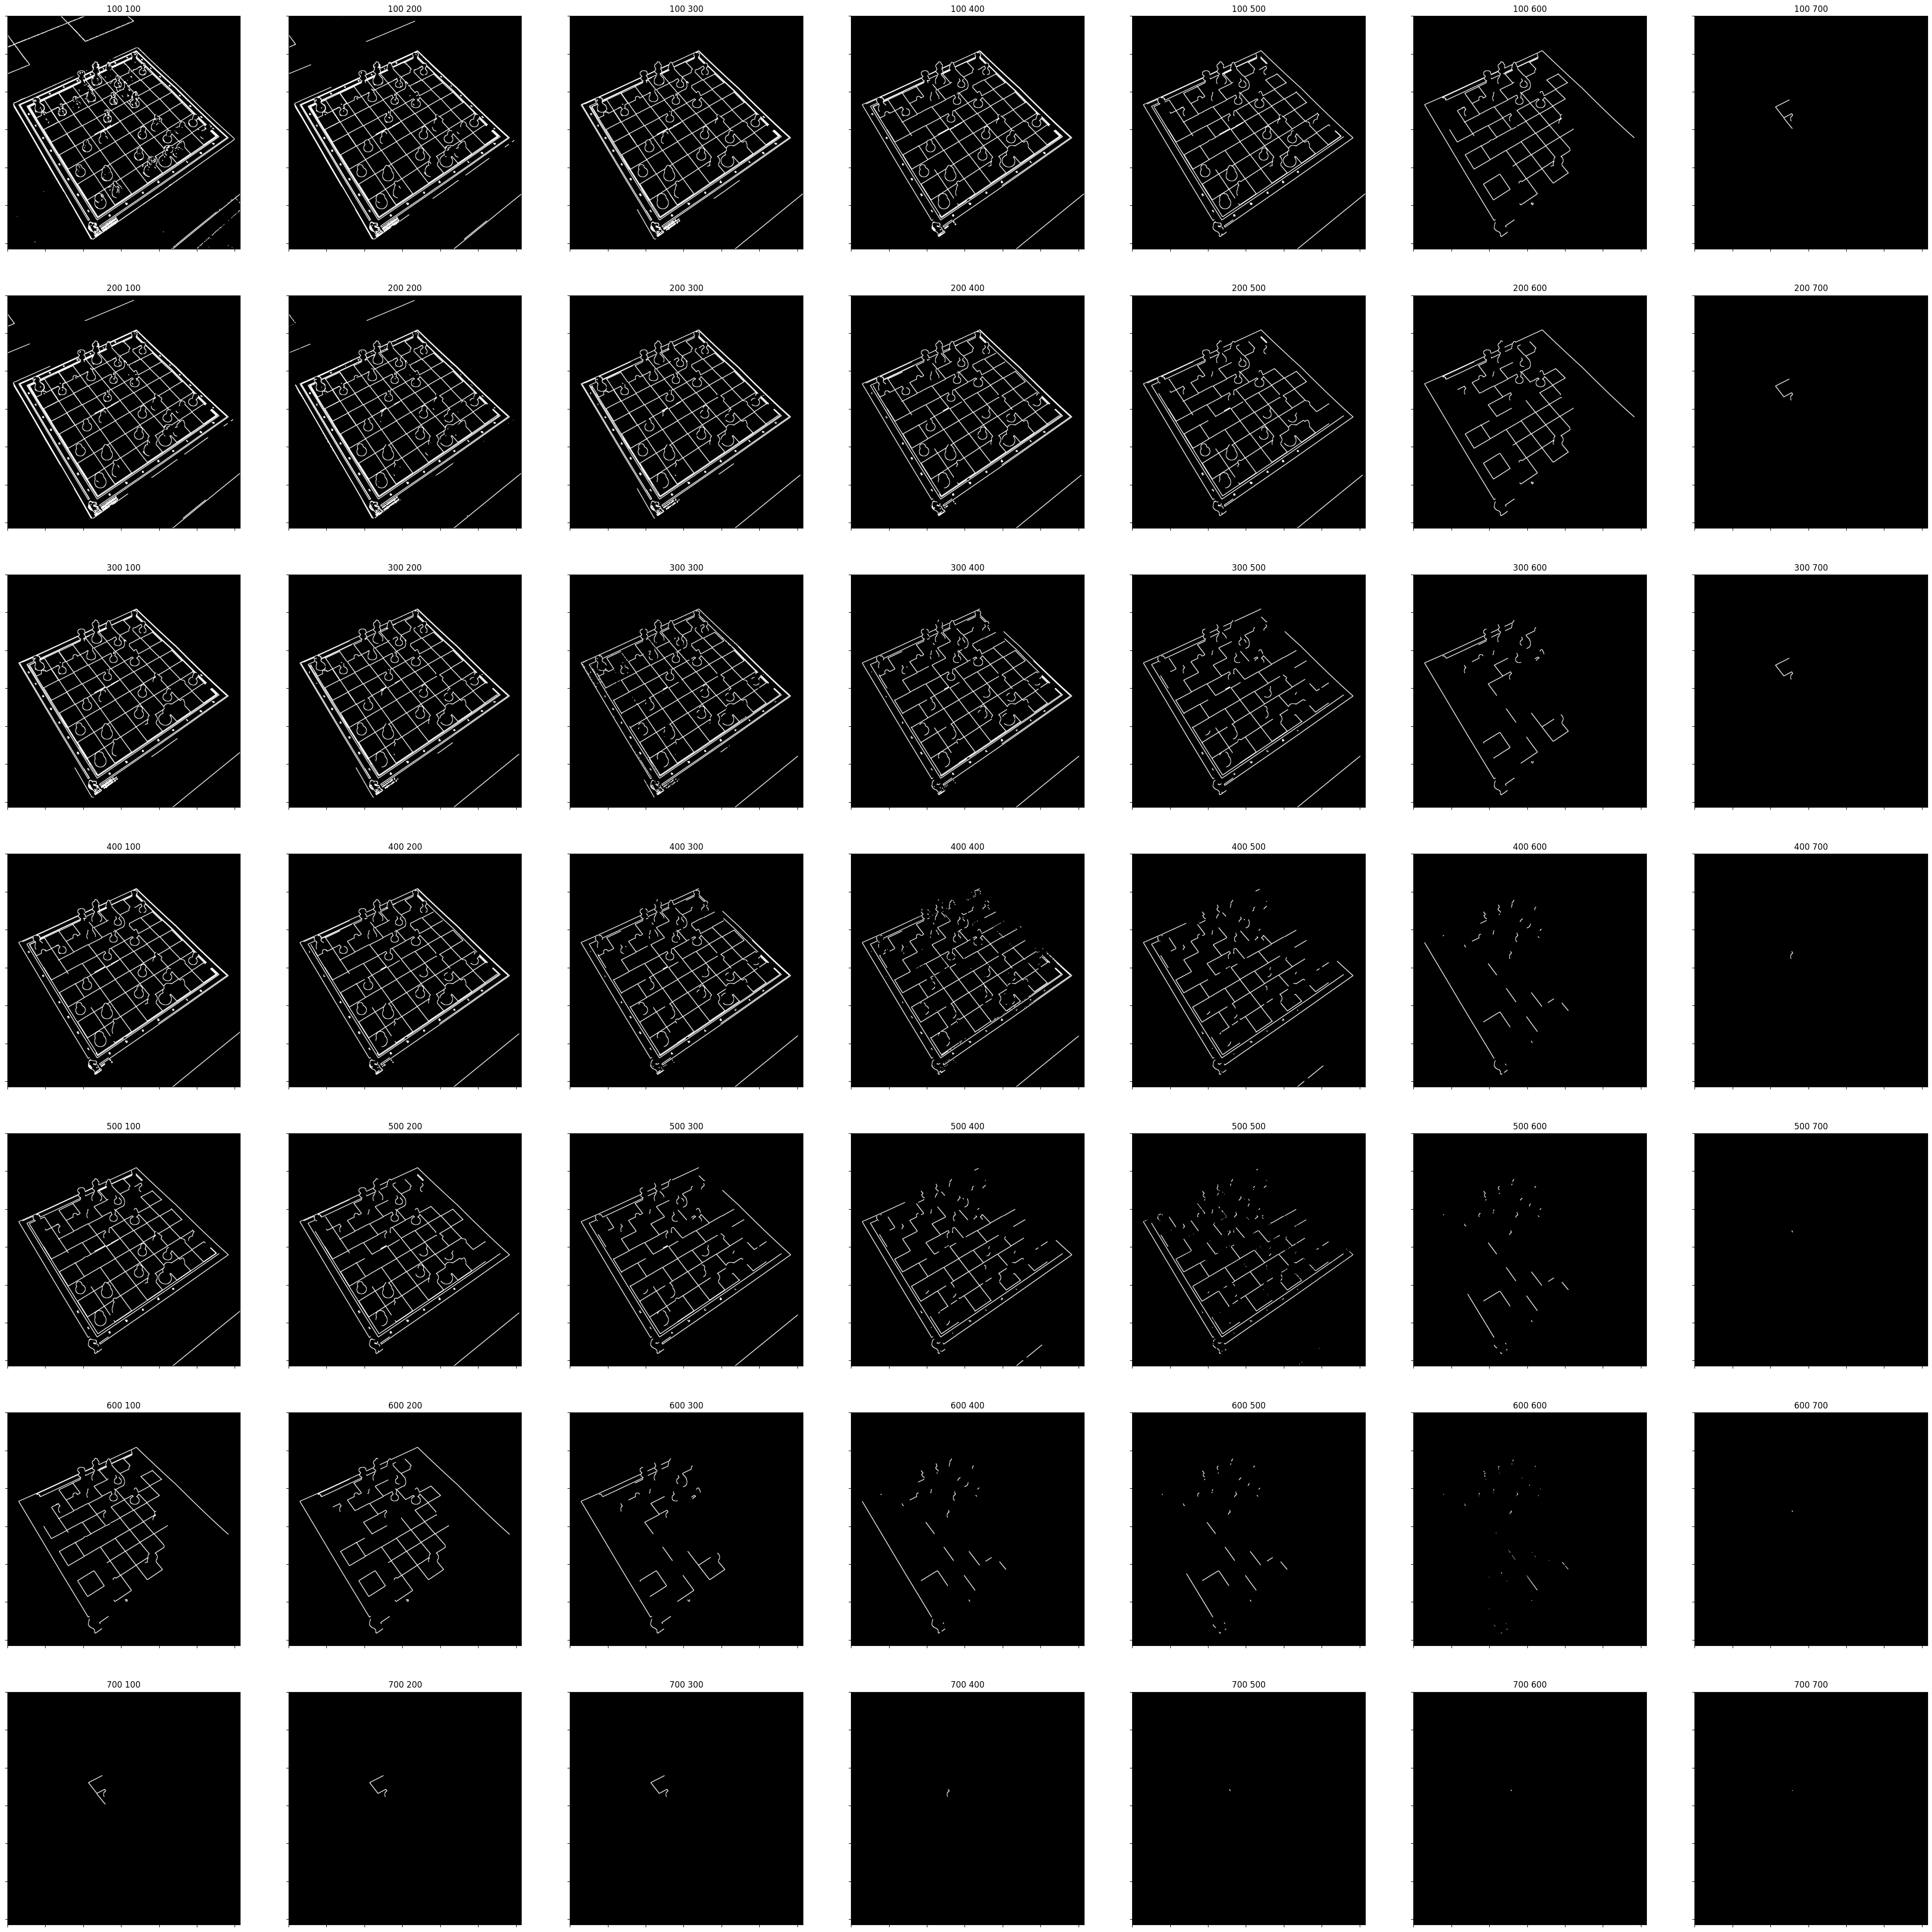

In [16]:
import itertools

t1 = [100, 200, 300, 400, 500, 600, 700]
t2 = [100, 200, 300, 400, 500, 600, 700]

params = [x for x in itertools.product(t1, t2)]
cannies_images = []


rows = len(t1)
cols = len(t2)

can_kernel = np.ones((7, 7), np.uint8)
plt.figure(figsize=(50,50))
for idx, (t1, t2) in enumerate(params):
    can = cv2.Canny(blurred_image, t1, t2) # é stato modificato questo input per creare le varie immagini
    can = cv2.dilate(can, can_kernel, iterations=1)
    cannies_images.append(can)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.title(f'{t1} {t2}')
    plt.imshow(can, cmap='gray')


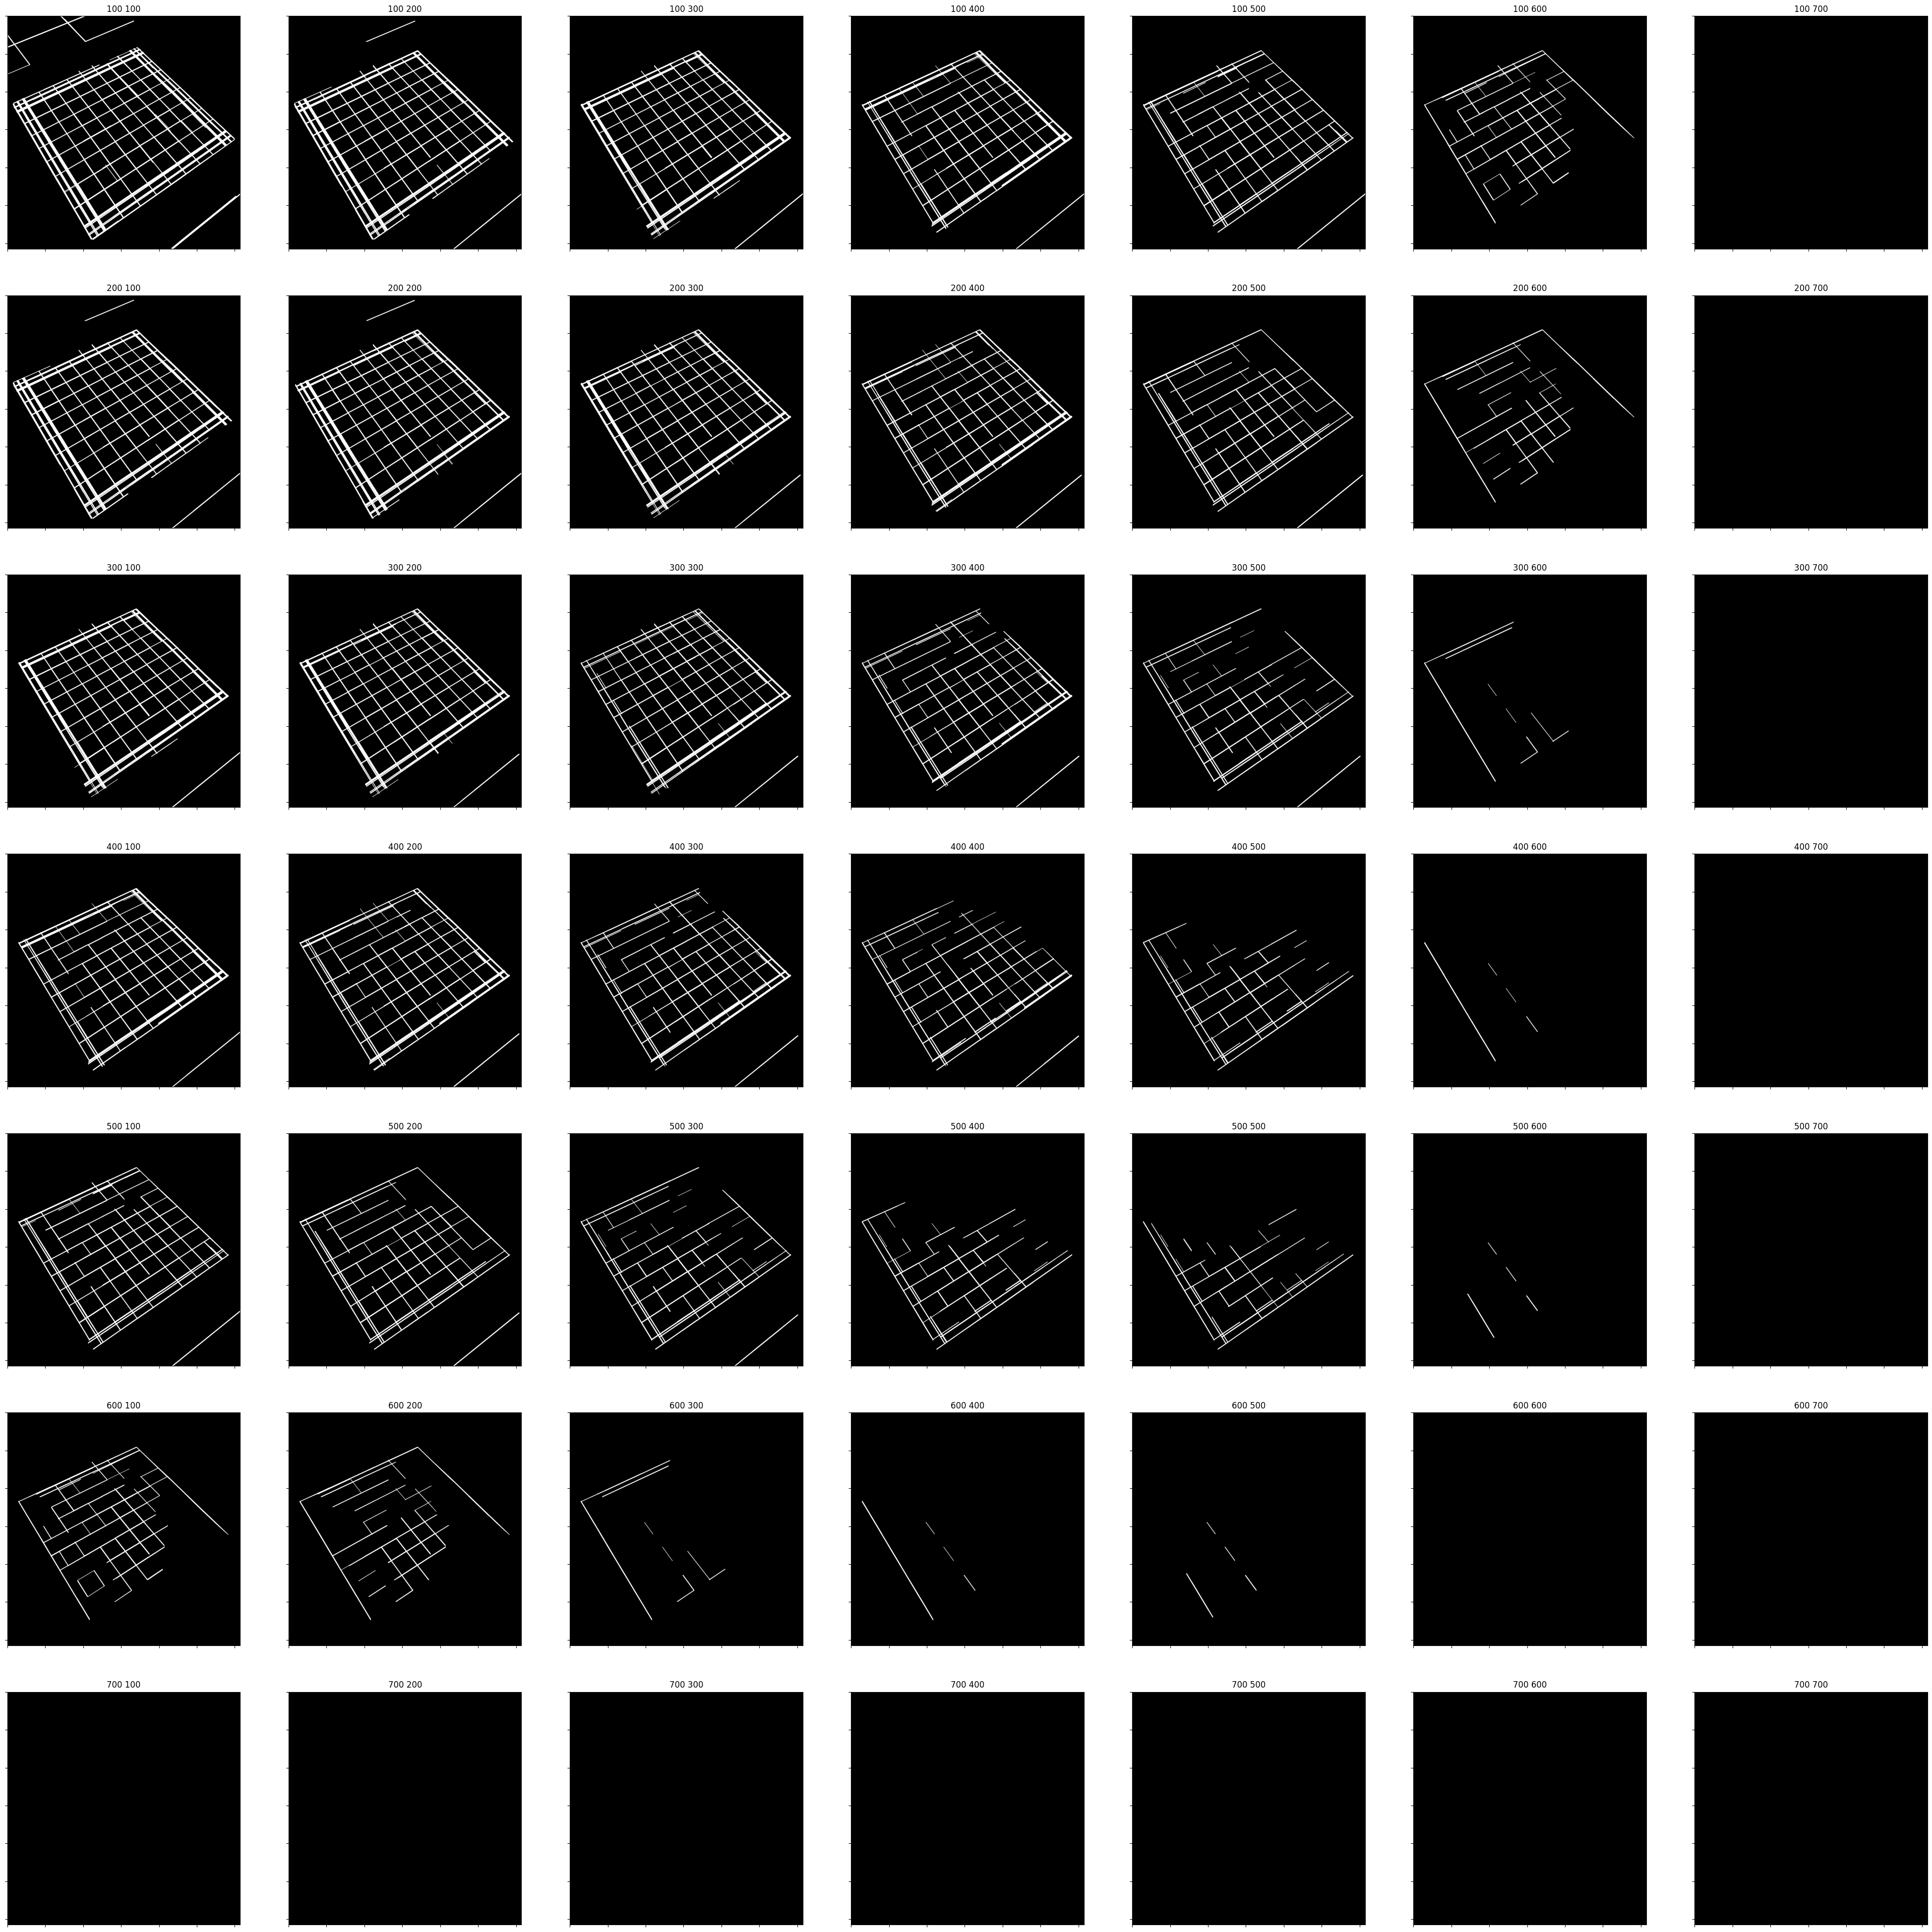

In [17]:
hough_images = []

plt.figure(figsize=(50,50))
for idx, (t1,t2) in enumerate(params):
    can = cannies_images[idx]

    # Hough Lines
    lines = cv2.HoughLinesP(can, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)
    # lines = link_and_merge_segments_array(lines[:, 0], image.shape[0]*image.shape[1])

    # Create an image that contains only black pixels
    black_image = np.zeros_like(can)

    # Draw only lines that are output of HoughLinesP function to the "black_image"
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # draw only lines to the "black_image"
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Dilation
    kernel = np.ones((3, 3), np.uint8)
    black_image = cv2.dilate(black_image, kernel, iterations=1)
    hough_images.append(black_image)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f'{t1} {t2}')
    plt.imshow(black_image, cmap='gray')

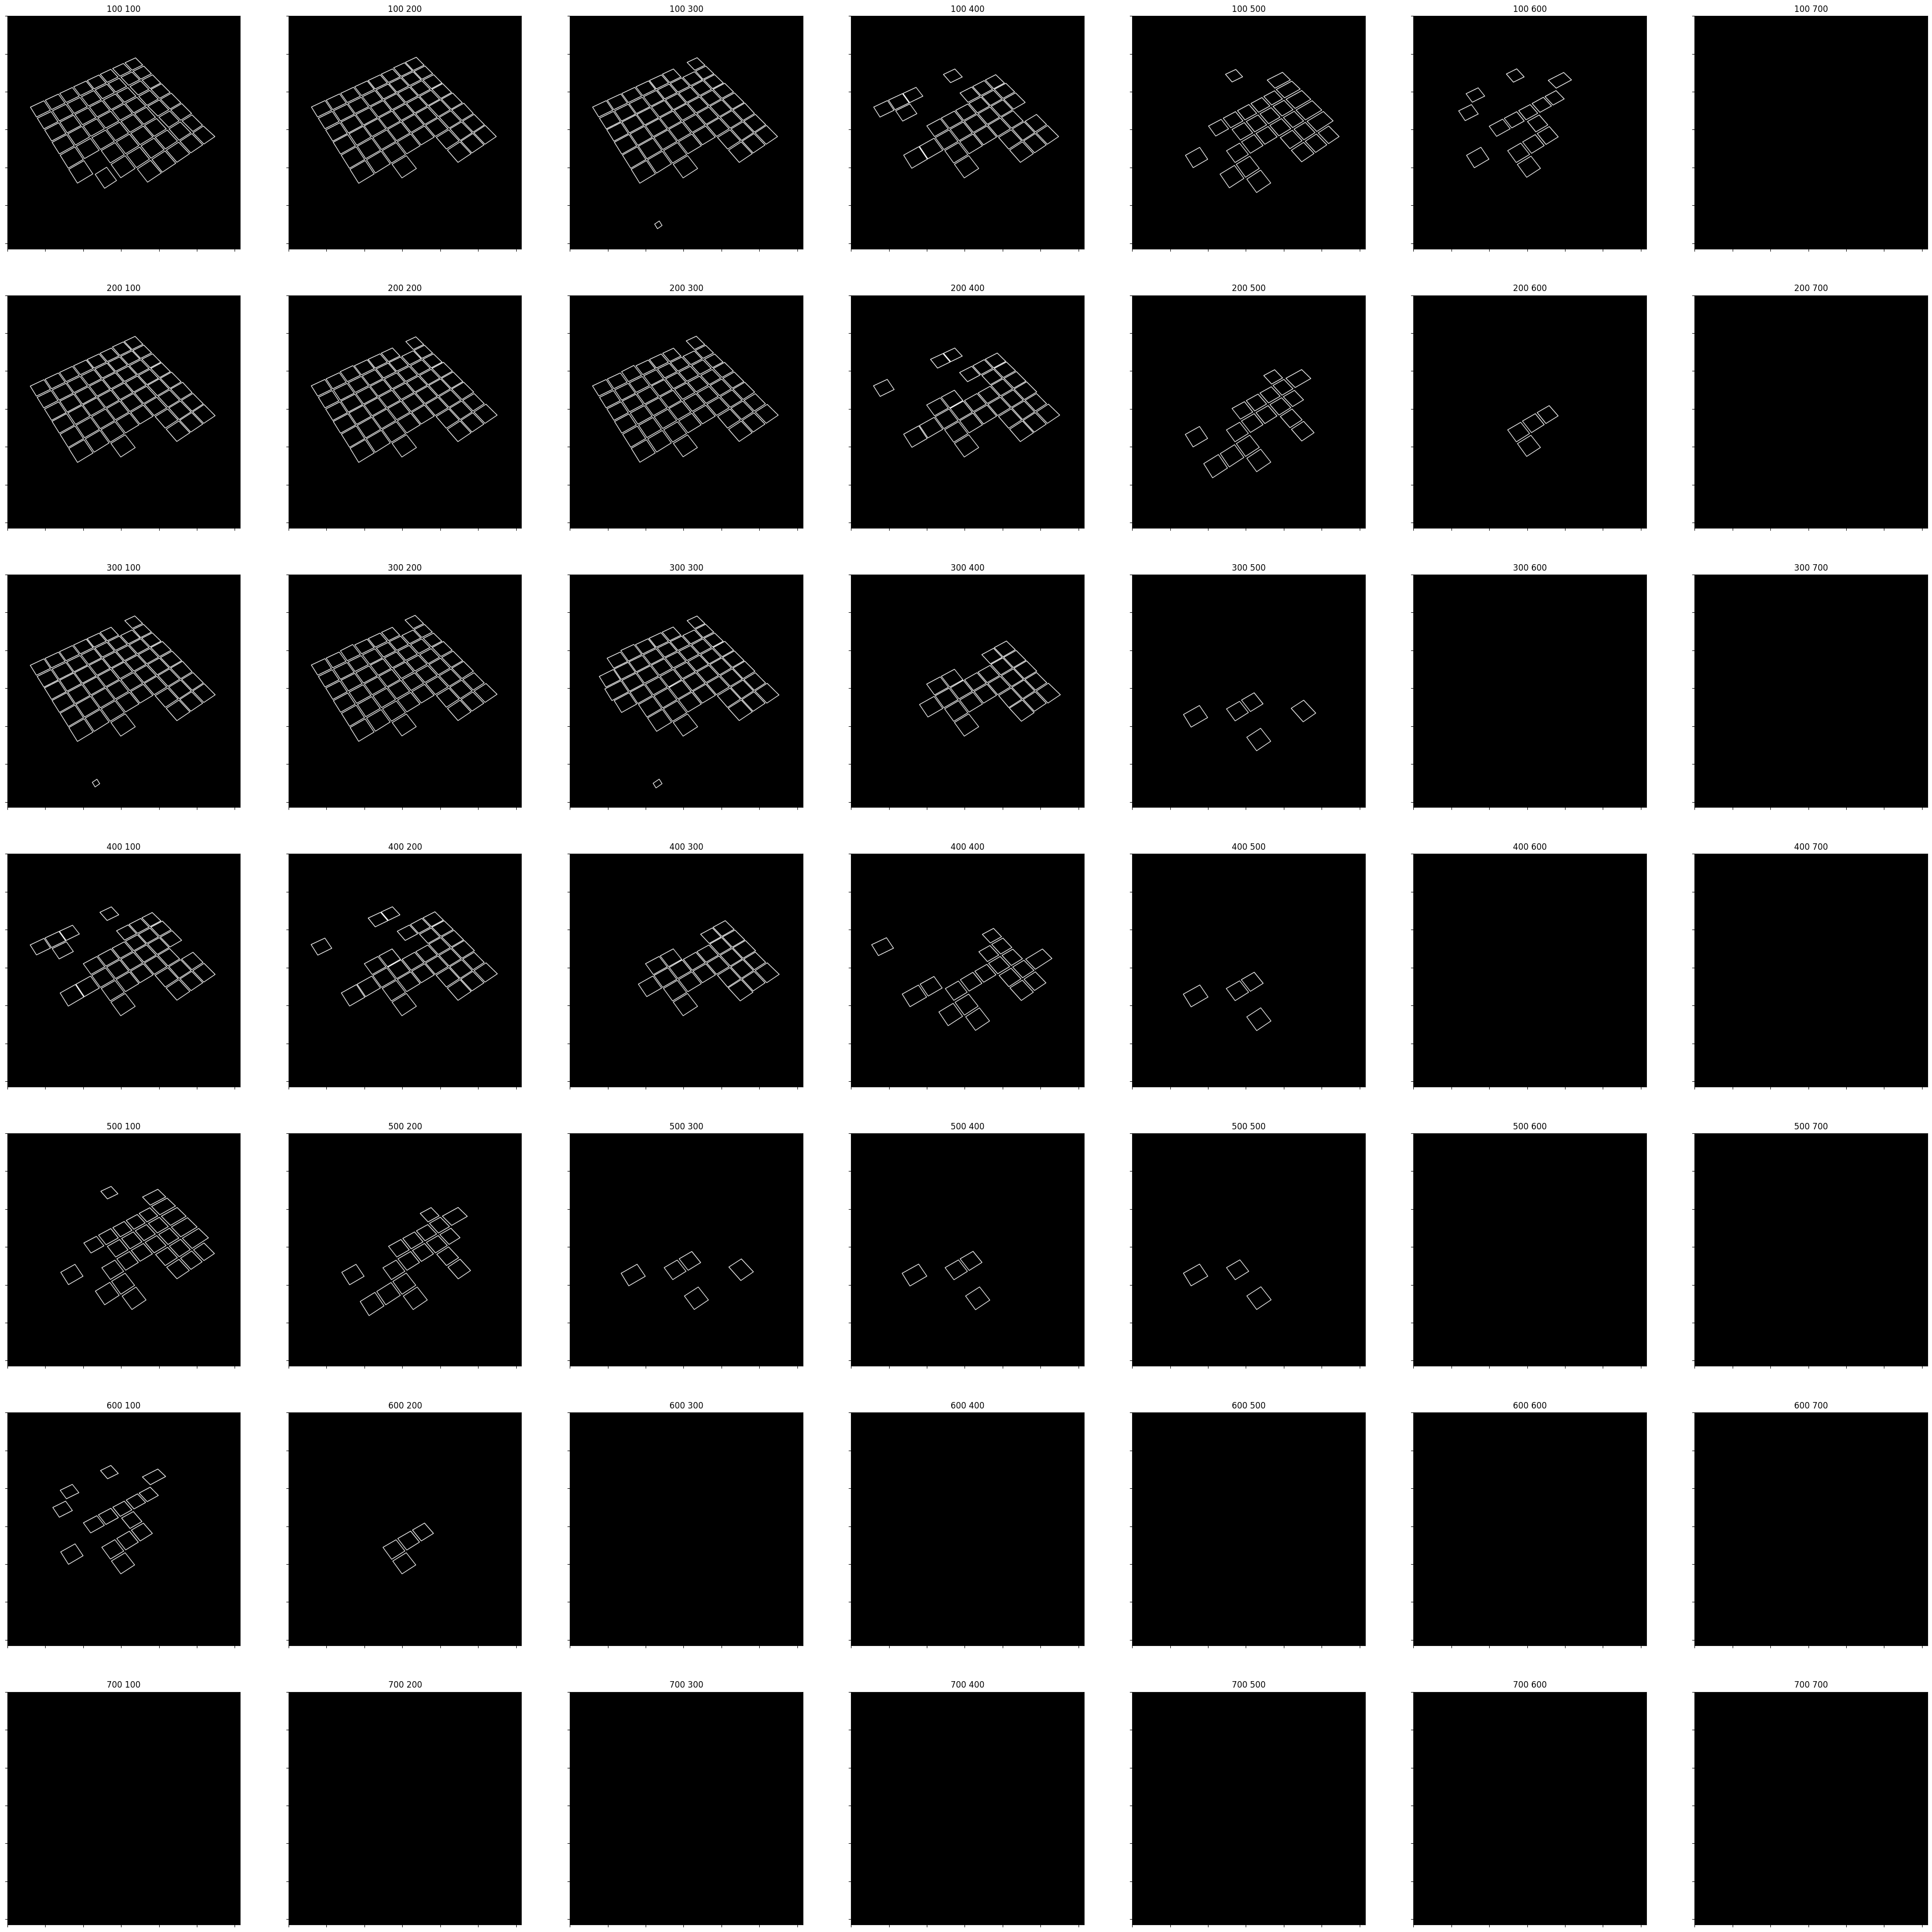

In [19]:
plt.figure(figsize=(50,50))
for idx, (t1,t2) in enumerate(params):
    black_image = hough_images[idx]

    # Look for valid squares and check if squares are inside of board
    board_contours = []
    # all_contours_image= np.zeros_like(black_image)
    valid_squares_image = np.zeros_like(black_image)
    new_black_image = black_image.copy()

    # find contours
    count = 0 
    while True:
        board_contours, hierarchy = cv2.findContours(new_black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(board_contours) == 0:
            break

        # passaggio evitabile, teoricamente modifica l'immagine con dilate in modo che aumenti la percentuale di poligoniu con 4 punti
        # break
        polynum = np.array([len(cv2.approxPolyDP(x, 0.02 * cv2.arcLength(x, True), True)) for x in board_contours])
        polynum_cat = np.unique(polynum)
        polynum_nums = np.zeros_like(polynum_cat)
        for cat_idx, cat in enumerate(polynum_cat):
            polynum_nums[cat_idx] = np.sum(polynum[polynum == cat])
        polynum_nums = polynum_nums / np.sum(polynum_nums)

        sorting_polynums_index = np.argsort(polynum_nums)[::-1]
        sorted_cats = polynum_cat[sorting_polynums_index]
        sorted_nums = polynum_nums[sorting_polynums_index]

        if (sorted_cats[0] == 4 and sorted_nums[0] >= 0.8) or count >= 5:
            # plt.figure(figsize=(12,8))
            # plt.bar(polynum_cat, polynum_nums)
            # plt.show()
            break

        kernel = np.ones((3, 3), np.uint8)
        new_black_image = cv2.dilate(new_black_image, kernel, iterations=1)
        count += 1


    # loop through contours and filter them by deciding if they are potential squares

    for contour in board_contours:
        if 2000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
            # Approximate the contour to a simpler shape
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
                
            if len(approx) == 4:
                # 4 points of polygon
                pts = [pt[0].tolist() for pt in approx]
                # pts = approx[0]

                # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

                #  Y values
                if index_sorted[0][1]< index_sorted[1][1]:
                    cur=index_sorted[0]
                    index_sorted[0] =  index_sorted[1]
                    index_sorted[1] = cur

                if index_sorted[2][1]> index_sorted[3][1]:
                    cur=index_sorted[2]
                    index_sorted[2] =  index_sorted[3]
                    index_sorted[3] = cur

                # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                pt1=index_sorted[0]
                pt2=index_sorted[1]
                pt3=index_sorted[2]
                pt4=index_sorted[3]

                # find rectangle that fits 4 point 
                x, y, w, h = cv2.boundingRect(contour)
                # find center of rectangle 
                center_x=(x+(x+w))/2
                center_y=(y+(y+h))/2

                

                # calculate length of 4 side of rectangle
                l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
                l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
                l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
                l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)


                # Create a list of lengths
                lengths = [l1, l2, l3, l4]
                
                # Get the maximum and minimum lengths
                max_length = max(lengths)
                min_length = min(lengths)

                # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
                if (max_length - min_length) <= 35 * scale_factor: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                    valid_square=True
                else:
                    valid_square=False

                if valid_square:
                    # Draw only valid squares to "valid_squares_image"
                    cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f'{t1} {t2}')
    plt.imshow(valid_squares_image, cmap='gray')


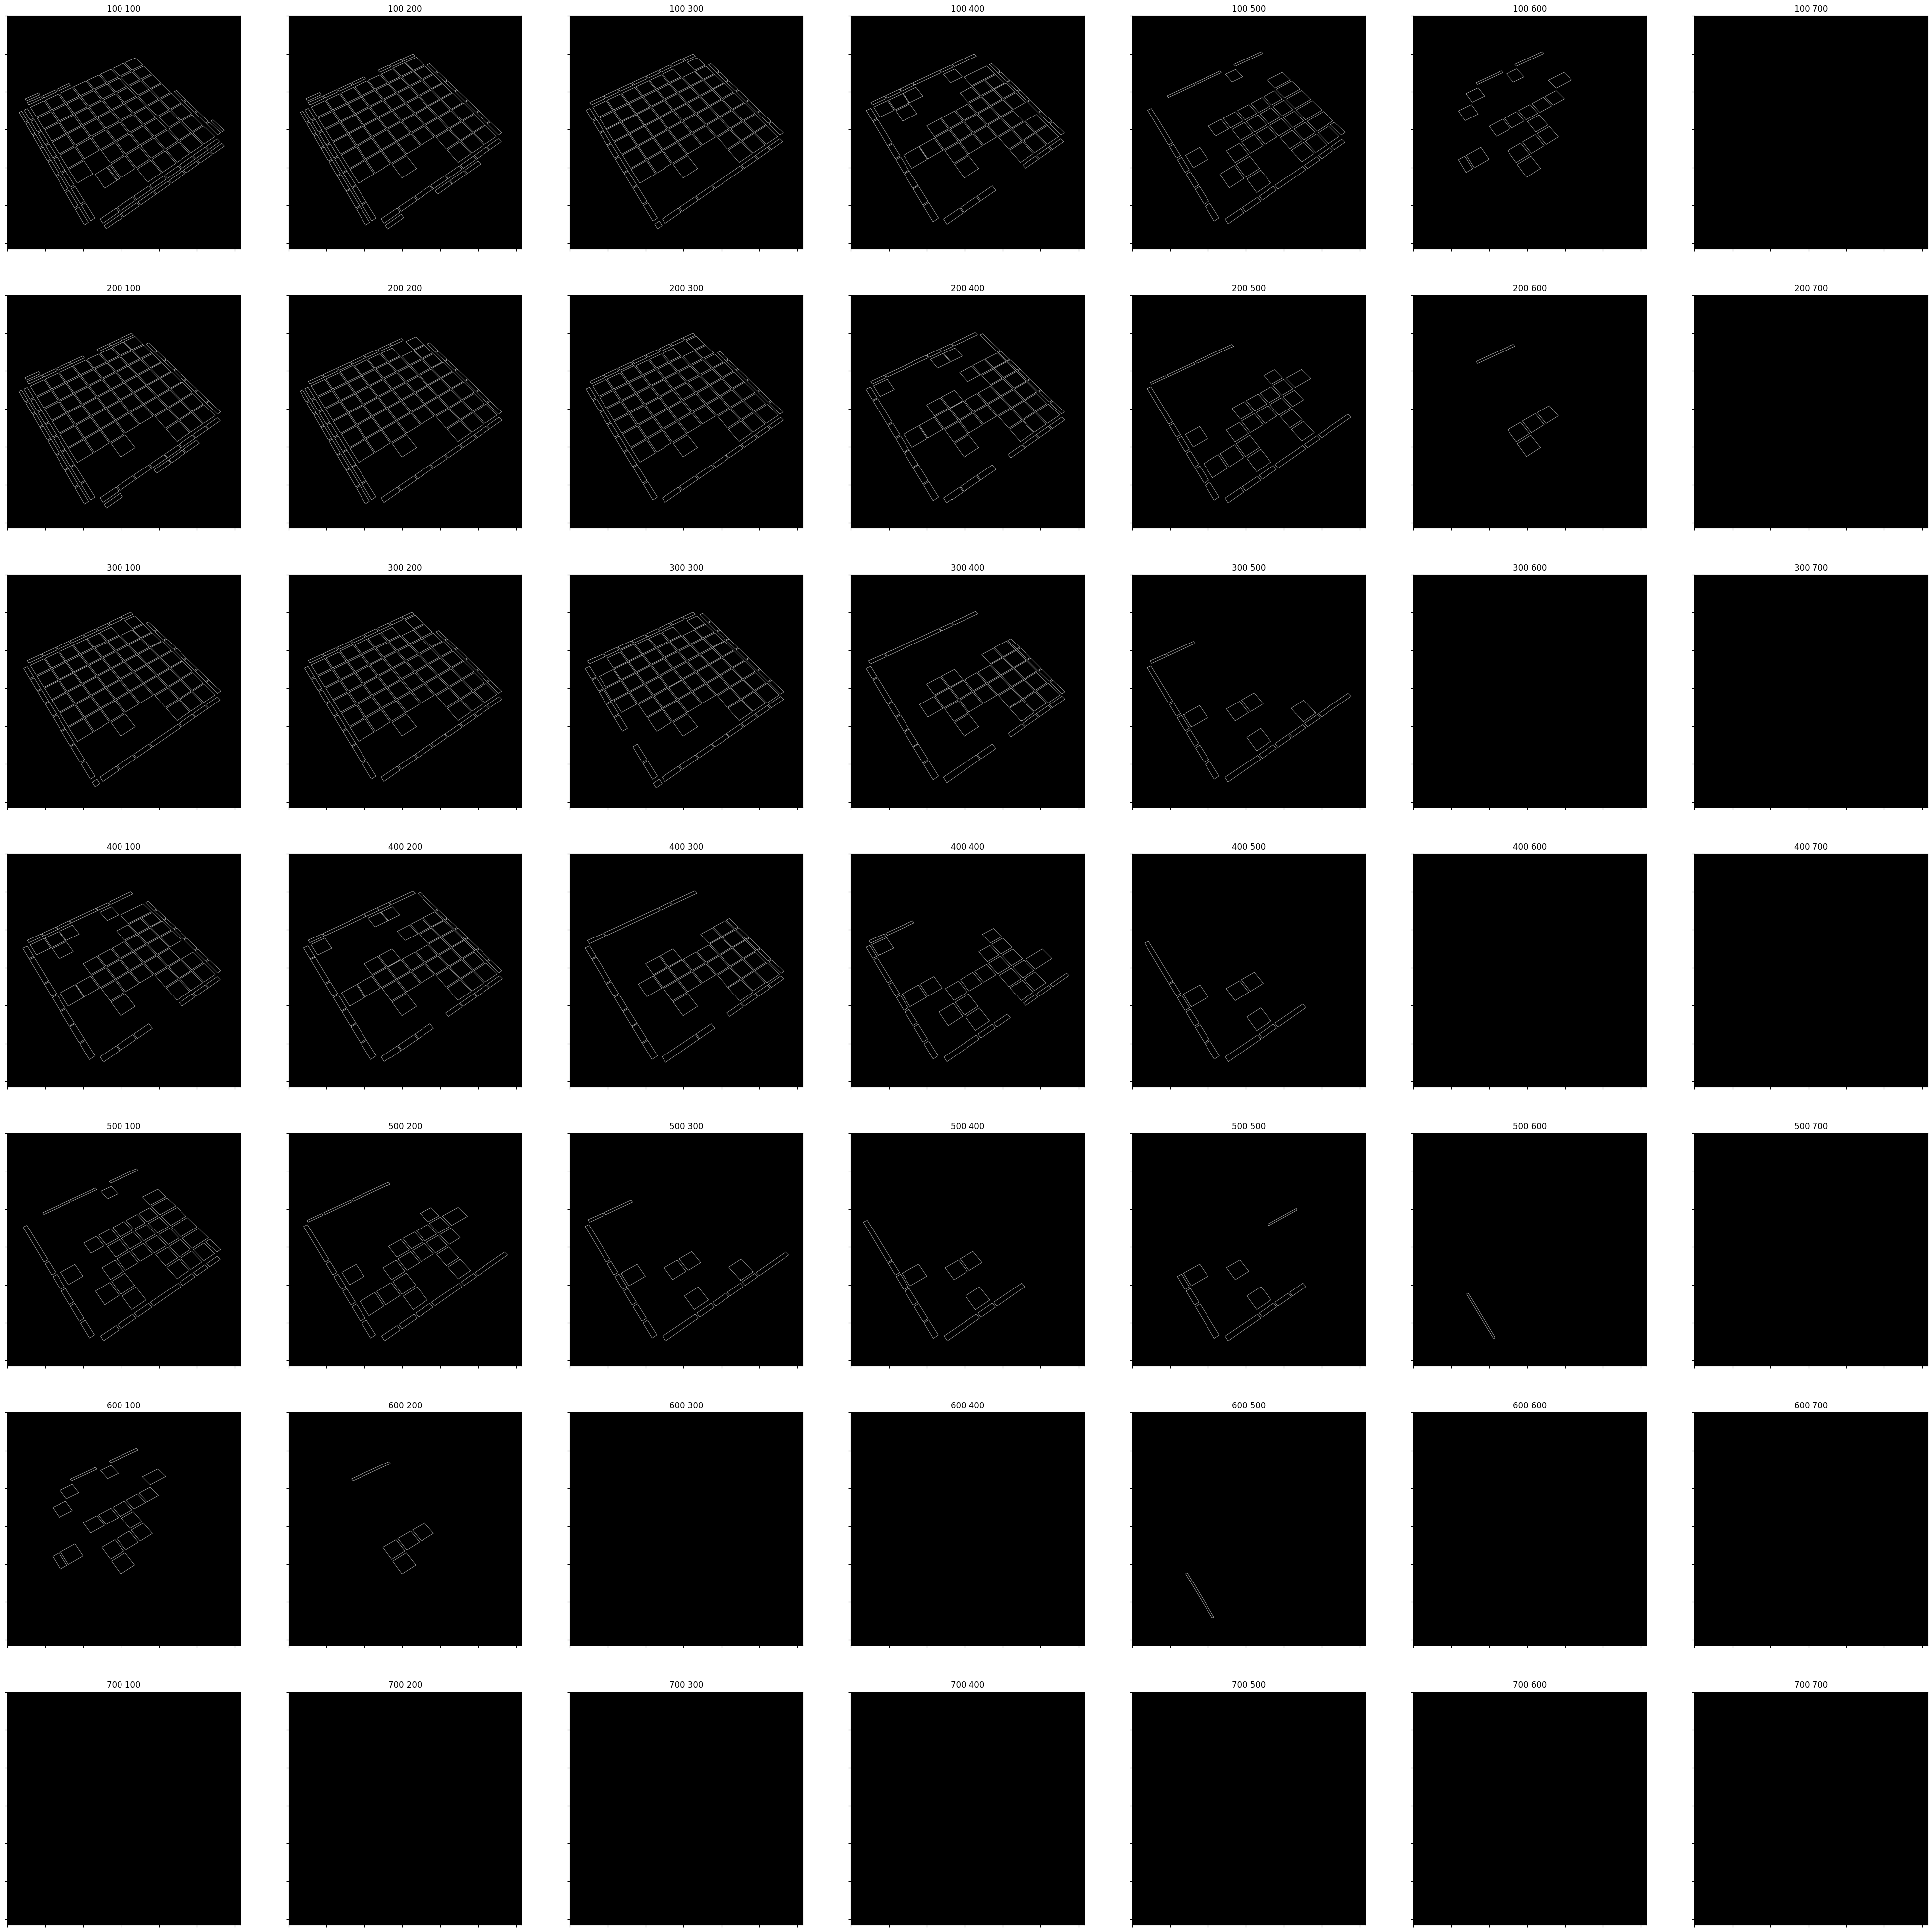

In [18]:
plt.figure(figsize=(50,50))
for idx, (t1,t2) in enumerate(params):
    black_image = hough_images[idx]

    # Look for valid squares and check if squares are inside of board
    board_contours = []
    # all_contours_image= np.zeros_like(black_image)
    valid_squares_image = np.zeros_like(black_image)
    new_black_image = black_image.copy()

    # find contours
    count = 0 
    while True:
        board_contours, hierarchy = cv2.findContours(new_black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(board_contours) == 0:
            break

        # passaggio evitabile, teoricamente modifica l'immagine con dilate in modo che aumenti la percentuale di poligoniu con 4 punti
        # break
        polynum = np.array([len(cv2.approxPolyDP(x, 0.02 * cv2.arcLength(x, True), True)) for x in board_contours])
        polynum_cat = np.unique(polynum)
        polynum_nums = np.zeros_like(polynum_cat)
        for cat_idx, cat in enumerate(polynum_cat):
            polynum_nums[cat_idx] = np.sum(polynum[polynum == cat])
        polynum_nums = polynum_nums / np.sum(polynum_nums)

        sorting_polynums_index = np.argsort(polynum_nums)[::-1]
        sorted_cats = polynum_cat[sorting_polynums_index]
        sorted_nums = polynum_nums[sorting_polynums_index]

        if (sorted_cats[0] == 4 and sorted_nums[0] >= 0.8) or count >= 5:
            # plt.figure(figsize=(12,8))
            # plt.bar(polynum_cat, polynum_nums)
            # plt.show()
            break

        kernel = np.ones((3, 3), np.uint8)
        new_black_image = cv2.dilate(new_black_image, kernel, iterations=1)
        count += 1


    # loop through contours and filter them by deciding if they are potential squares

    draw_contours = []
    for contour in board_contours:
        if 2000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
            # Approximate the contour to a simpler shape
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) == 4:
                draw_contours.append(contour)

    if len(draw_contours) > 0:
        cv2.drawContours(valid_squares_image, draw_contours, -1, 255, 3)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f'{t1} {t2}')
    plt.imshow(valid_squares_image, cmap='gray')
